In [1]:
import random
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import tifffile as tiff
from matplotlib.patches import Rectangle

In [2]:
def visualize_samples(
    dataset_root,
    num_samples=6,
    split='train',
    show_positive_only=False,
    show_negative_only=False,
    seed=None
):
    """
    Advanced visualization with more options
    
    Args:
        dataset_root: Path to dataset_output directory
        num_samples: Number of samples to visualize
        split: 'train' or 'val'
        show_positive_only: Only show samples with objects
        show_negative_only: Only show negative samples
        seed: Random seed for reproducibility
    """
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)
    
    dataset_root = Path(dataset_root)
    images_dir = dataset_root / split / 'images'
    labels_dir = dataset_root / split / 'labels'
    
    # Load class names
    try:
        import yaml
        with open(dataset_root / 'data.yaml', 'r') as f:
            data = yaml.safe_load(f)
            class_names = data.get('names', [])
    except:
        class_names = ['Backpack', 'Jacket', 'Laptop', 'Lifering', 
                      'Mobilephone', 'Person1', 'WaterBottle']
    
    # Get all image files
    image_files = sorted(list(images_dir.glob('*.tif')))
    if not image_files:
        print(f"❌ No images found in {images_dir}")
        return
    
    # Filter by positive/negative if needed
    if show_positive_only or show_negative_only:
        filtered_files = []
        for img_file in image_files:
            label_file = labels_dir / f"{img_file.stem}.txt"
            has_objects = label_file.exists() and len(label_file.read_text().strip()) > 0
            
            if show_positive_only and has_objects:
                filtered_files.append(img_file)
            elif show_negative_only and not has_objects:
                filtered_files.append(img_file)
        
        if not filtered_files:
            print(f"⚠️  No samples found with specified filter")
            return
        image_files = filtered_files
    
    # Select random samples
    selected_files = random.sample(image_files, min(num_samples, len(image_files)))
    
    # Create figure
    cols = 2
    rows = len(selected_files)
    fig, axes = plt.subplots(rows, cols, figsize=(14, 5 * rows))
    if rows == 1:
        axes = axes.reshape(1, -1)
    
    colors = plt.cm.tab10(np.linspace(0, 1, len(class_names)))
    
    for idx, image_file in enumerate(selected_files):
        # Load 6-channel TIFF
        six_channel = tiff.imread(str(image_file))
        
        # Split channels
        reference = six_channel[:, :, 0:3].astype(np.uint8)
        query = six_channel[:, :, 3:6].astype(np.uint8)
        
        # Load labels
        label_file = labels_dir / f"{image_file.stem}.txt"
        bboxes = []
        if label_file.exists():
            with open(label_file, 'r') as f:
                lines = f.read().strip().split('\n')
                for line in lines:
                    if line.strip():
                        parts = line.split()
                        if len(parts) == 5:
                            class_id, x_center, y_center, width, height = map(float, parts)
                            class_id = int(class_id)
                            
                            h, w = query.shape[:2]
                            x1 = int((x_center - width/2) * w)
                            y1 = int((y_center - height/2) * h)
                            x2 = int((x_center + width/2) * w)
                            y2 = int((y_center + height/2) * h)
                            
                            bboxes.append({
                                'class_id': class_id,
                                'class_name': class_names[class_id] if class_id < len(class_names) else f'Class_{class_id}',
                                'bbox': [x1, y1, x2, y2],
                                'color': colors[class_id % len(colors)]
                            })
        
        # Display reference
        axes[idx, 0].imshow(reference)
        axes[idx, 0].set_title(f'📷 Reference (Template)\n{image_file.name}', 
                              fontsize=11, fontweight='bold')
        axes[idx, 0].axis('off')
        
        # Display query with bboxes
        axes[idx, 1].imshow(query)
        
        # Draw bboxes using matplotlib
        for bbox_info in bboxes:
            x1, y1, x2, y2 = bbox_info['bbox']
            rect = Rectangle(
                (x1, y1), x2-x1, y2-y1,
                linewidth=2, 
                edgecolor=bbox_info['color'], 
                facecolor='none'
            )
            axes[idx, 1].add_patch(rect)
            
            # Add label
            axes[idx, 1].text(
                x1, y1 - 5, 
                bbox_info['class_name'],
                bbox=dict(boxstyle='round,pad=0.3', facecolor=bbox_info['color'], alpha=0.7),
                fontsize=9,
                color='white',
                fontweight='bold'
            )
        
        # Title for query
        title = f'🎯 Query (Frame)'
        if bboxes:
            title += f'\n✅ {len(bboxes)} object(s) detected'
            class_list = ', '.join(set([b['class_name'] for b in bboxes]))
            title += f'\nClasses: {class_list}'
        else:
            title += '\n❌ Negative sample (no objects)'
        title += f'\n{image_file.name}'
        axes[idx, 1].set_title(title, fontsize=11, fontweight='bold')
        axes[idx, 1].axis('off')
    
    plt.suptitle(f'Siamese Dataset Visualization - {split.upper()} Split', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    # Statistics
    total_positive = sum(1 for f in selected_files 
                        if (labels_dir / f"{f.stem}.txt").exists() 
                        and len((labels_dir / f"{f.stem}.txt").read_text().strip()) > 0)
    
    print(f"\n{'='*70}")
    print(f"📊 VISUALIZATION SUMMARY")
    print(f"{'='*70}")
    print(f"Split: {split.upper()}")
    print(f"Samples shown: {len(selected_files)}")
    print(f"  - Positive samples: {total_positive}")
    print(f"  - Negative samples: {len(selected_files) - total_positive}")
    print(f"Total samples in {split}: {len(list(images_dir.glob('*.tif')))}")
    print(f"{'='*70}\n")


/tmp/ipykernel_2384/3880378682.py:151: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2384/3880378682.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2384/3880378682.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2384/3880378682.py:151: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/t1tc01-hoangphan/code/t1tc01-personal/aero-eyes-zalo-challenger-2025/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/t1tc01-hoangphan/code/t1tc01-personal/aero-eyes-zalo-challenger-2025/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing

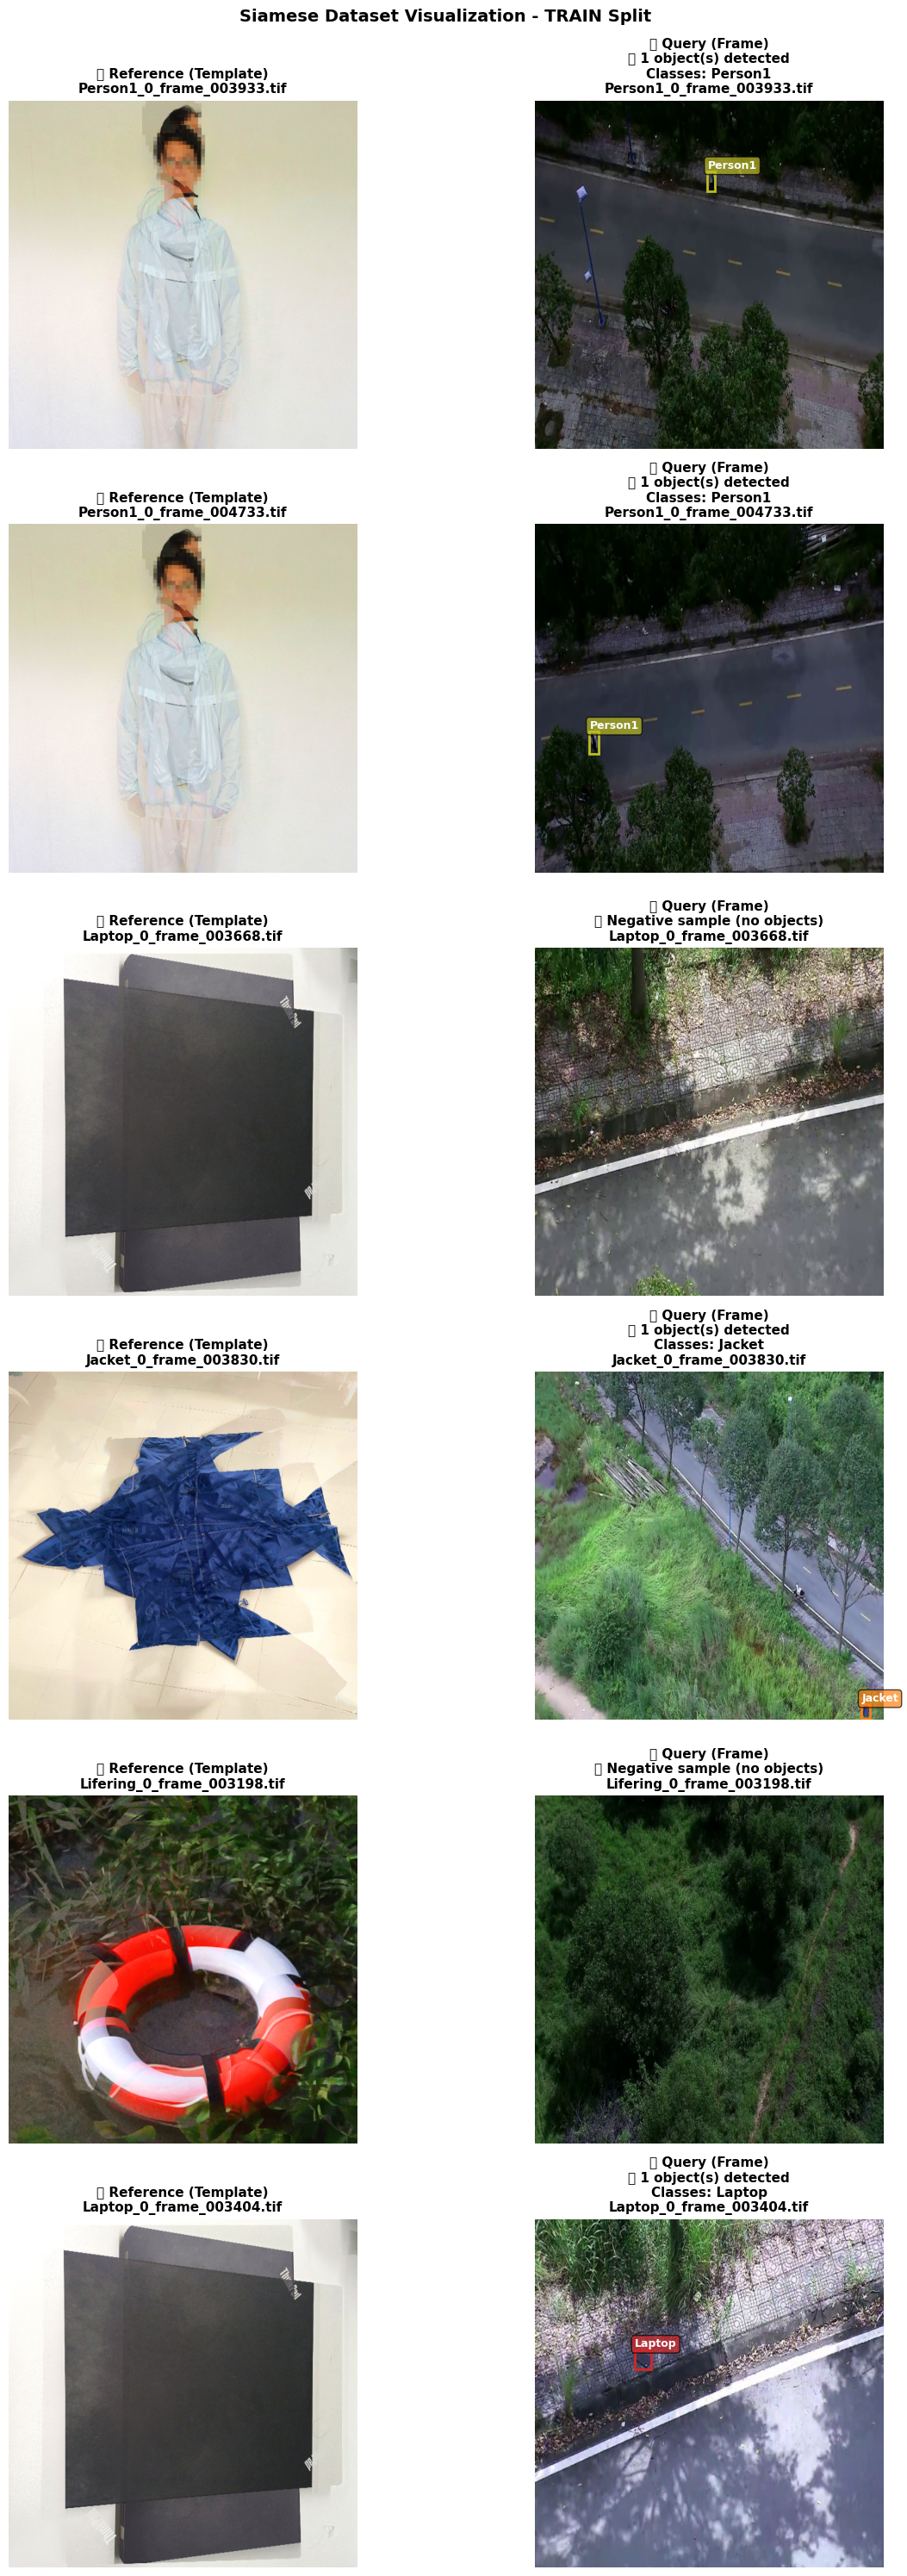


📊 VISUALIZATION SUMMARY
Split: TRAIN
Samples shown: 6
  - Positive samples: 4
  - Negative samples: 2
Total samples in train: 18646



In [3]:
# Sử dụng
OUTPUT_ROOT = '/home/t1tc01-hoangphan/code/t1tc01-personal/ultralytics_sia-aero-eyes-Zalo-2025/dataset_output'

# Visualize random samples
visualize_samples(
    dataset_root=OUTPUT_ROOT,
    num_samples=6,
    split='train'
)

/tmp/ipykernel_2384/3880378682.py:151: UserWarning: Glyph 128247 (\N{CAMERA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2384/3880378682.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_2384/3880378682.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


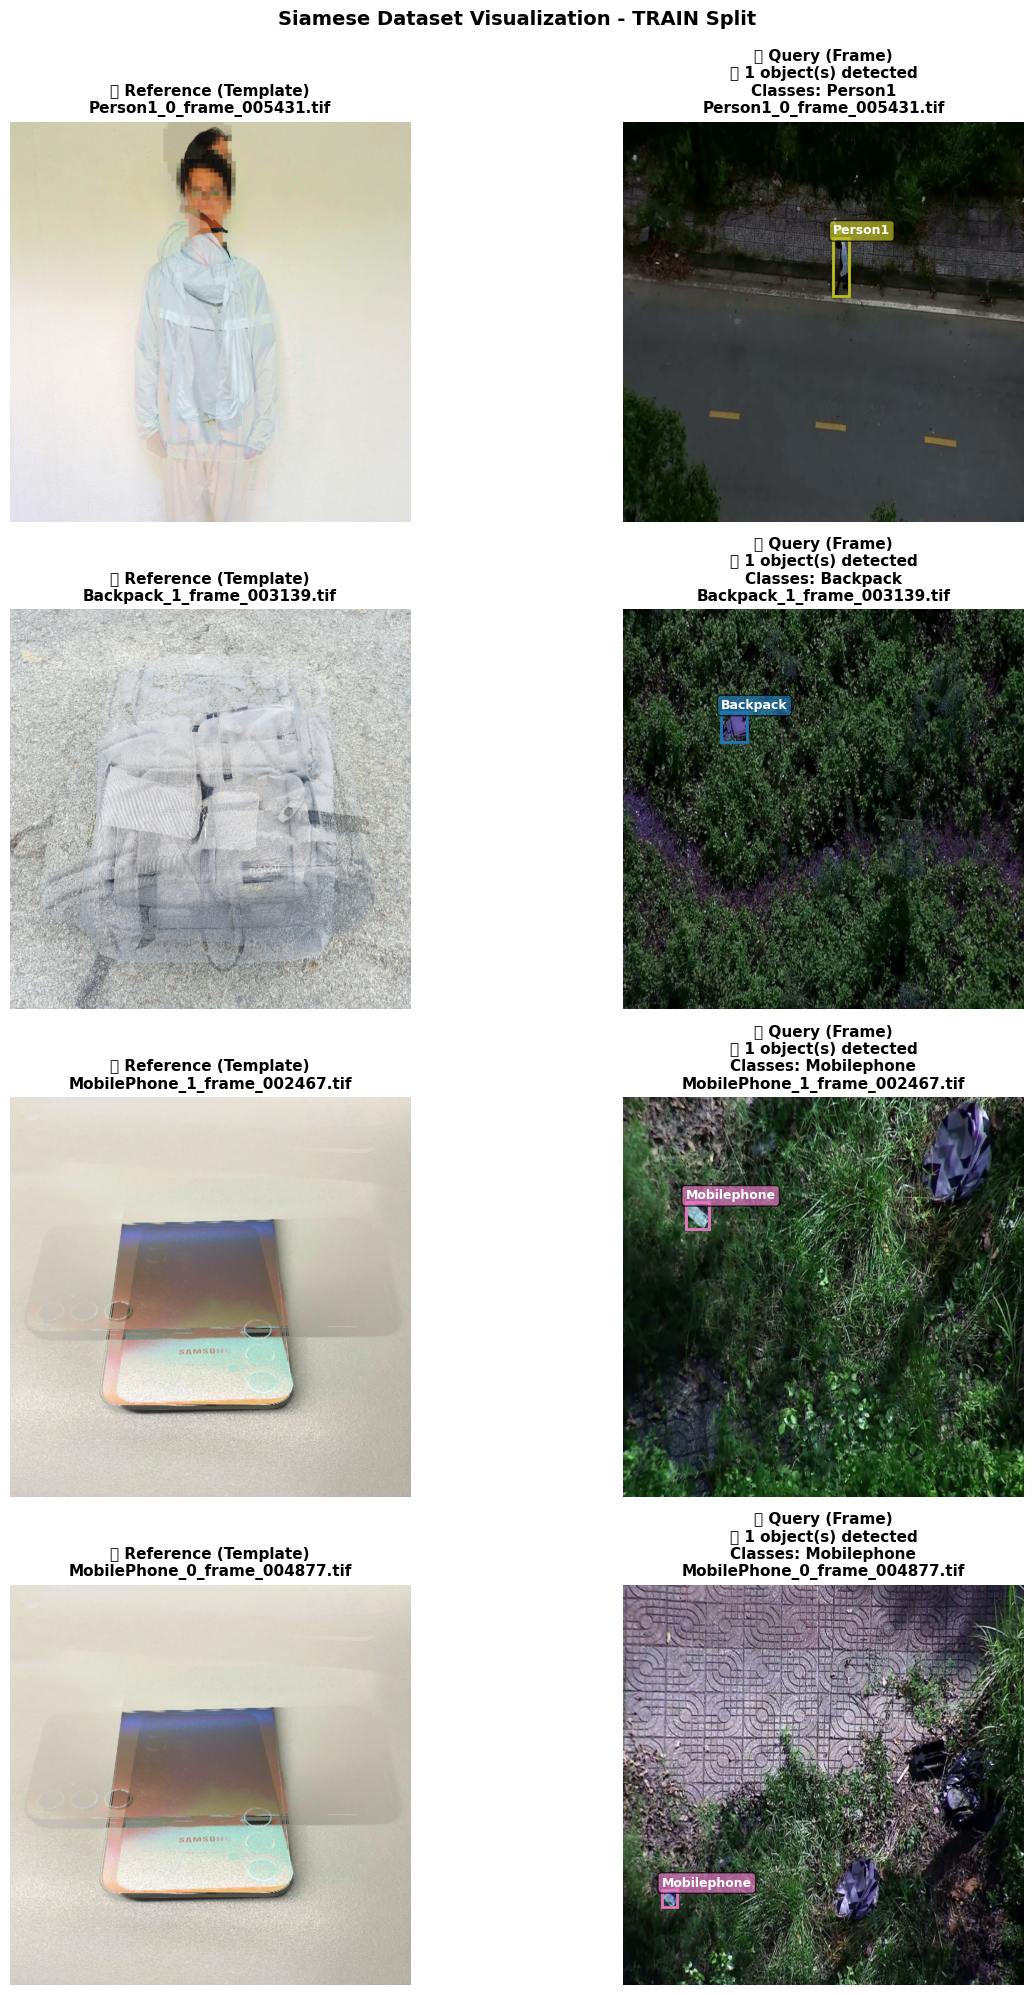


📊 VISUALIZATION SUMMARY
Split: TRAIN
Samples shown: 4
  - Positive samples: 4
  - Negative samples: 0
Total samples in train: 18646



In [4]:
#Chỉ xem positive samples
visualize_samples(
    dataset_root=OUTPUT_ROOT,
    num_samples=4,
    split='train',
    show_positive_only=True
)

In [ ]:

# Chỉ xem negative samples
# visualize_samples_advanced(
#     dataset_root=OUTPUT_ROOT,
#     num_samples=4,
#     split='train',
#     show_negative_only=True
# )